In [13]:
import os
import numpy as np
import pandas as pd
import pandasql as ps
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar")

import gensim 
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

LabeledSentence = gensim.models.doc2vec.LabeledSentence

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
os.chdir('C:\\Users\\BTHANISH\\Documents\\Thanish\\Competition\\Hacker earth\\Amazon Hiring Challenge')


In [14]:
DF_train_prod = pd.read_csv('train.csv')
DF_test_prod = pd.read_csv('test.csv')
#DF_test_prod = DF_test_prod.loc[~DF_test_prod.duplicated(),]

print(DF_train_prod.shape, DF_test_prod.shape)

DF_test_prod['topic'] = 'Test_dataset'
DF_prod = pd.concat([DF_train_prod, DF_test_prod]).reset_index(drop = True)
DF_prod.columns = ['Review_text', 'Review_Title', 'topic']
DF_prod.head()

(5959, 3) (2553, 2)


,Review_text,Review_Title,topic
0,"Did nothing for me, didn't help lost even with...",Useless,Shipment and delivery
1,"Did nothing for me, didn't help lost even with...",Useless,Not Effective
2,I have bought these bags and immediately open...,TRASH!!! Do not buy these bags it’s a waist of...,Customer Service
3,Gave me an allergic reaction on my face :(,Do not recommend,Allergic
4,These don't compare to the name brand wipes. F...,Can't tackle big messes,Texture


In [15]:
stop = stopwords.words('english')

# Tokenizing the two columns Review_text, Review_Title
for col in ['Review_text', 'Review_Title']:
    #Converting the columns to lowercase
    DF_prod[col] = DF_prod[col].apply(lambda x :  x.lower())

    #Replacing the puncutations
    DF_prod[col] = DF_prod[col].str.replace('[^\w\s]','')
    
    # Removing stop words
    DF_prod[col] = DF_prod[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    # Removing stop words
    DF_prod[col] = DF_prod[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    # Remove numerics from the data
    DF_prod[col] = DF_prod[col].str.replace('\d+', '')
    
    #Getting the tokens for the two columns
    new_col = col + '_tokens'
    DF_prod[new_col] = DF_prod.apply(lambda row : word_tokenize(row[col]), axis = 1)

# Combined tokens
DF_prod['combined_tokens'] = DF_prod['Review_text_tokens'] + DF_prod['Review_Title_tokens']
DF_prod.head(10)

,Review_text,Review_Title,topic,Review_text_tokens,Review_Title_tokens,combined_tokens
0,nothing didnt help lost even working eating he...,useless,Shipment and delivery,"[nothing, didnt, help, lost, even, working, ea...",[useless],"[nothing, didnt, help, lost, even, working, ea..."
1,nothing didnt help lost even working eating he...,useless,Not Effective,"[nothing, didnt, help, lost, even, working, ea...",[useless],"[nothing, didnt, help, lost, even, working, ea..."
2,bought bags immediately open one put trash bag...,trash buy bags waist time,Customer Service,"[bought, bags, immediately, open, one, put, tr...","[trash, buy, bags, waist, time]","[bought, bags, immediately, open, one, put, tr..."
3,gave allergic reaction face,recommend,Allergic,"[gave, allergic, reaction, face]",[recommend],"[gave, allergic, reaction, face, recommend]"
4,dont compare name brand wipes family little k...,cant tackle big messes,Texture,"[dont, compare, name, brand, wipes, family, li...","[cant, tackle, big, messes]","[dont, compare, name, brand, wipes, family, li..."
5,dont compare name brand wipes family little k...,cant tackle big messes,Quality/Contaminated,"[dont, compare, name, brand, wipes, family, li...","[cant, tackle, big, messes]","[dont, compare, name, brand, wipes, family, li..."
6,dont compare name brand wipes family little k...,cant tackle big messes,Color and texture,"[dont, compare, name, brand, wipes, family, li...","[cant, tackle, big, messes]","[dont, compare, name, brand, wipes, family, li..."
7,good,tastes horrible,Bad Taste/Flavor,[good],"[tastes, horrible]","[good, tastes, horrible]"
8,extremely hard swallow pills huge sides sharp ...,choking hazard,Too big to swallow,"[extremely, hard, swallow, pills, huge, sides,...","[choking, hazard]","[extremely, hard, swallow, pills, huge, sides,..."
9,first style leaving review solimo incontinent ...,bring back old style,Quality/Contaminated,"[first, style, leaving, review, solimo, incont...","[bring, back, old, style]","[first, style, leaving, review, solimo, incont..."


# Splitting the data back to train prod and test prod

In [16]:
train_prod = DF_prod.loc[DF_prod.topic != 'Test_dataset',].reset_index(drop = True)
test_prod = DF_prod.loc[DF_prod.topic == 'Test_dataset',].reset_index(drop = True)

print(train_prod.shape, test_prod.shape)

# Get the indep and dep features
indep = ['combined_tokens']
dep = ['topic']

(5959, 6) (2553, 6)


In [17]:
# Convert the labels to integer
LE = LabelEncoder()
LE.fit(train_prod.topic)
train_prod.topic = LE.transform(train_prod.topic)


In [18]:
np.random.seed(100)
# train_local_X, test_local_X, train_local_Y, test_local_Y = train_test_split(train_prod[indep],
#                                                                             train_prod[dep],
#                                                                             test_size = 0.2)


# print(train_prod.shape)
# print(train_prod.loc[~train_prod.Review_text.duplicated(),].shape)
# train_prod = train_prod.loc[~train_prod.Review_text.duplicated(),]


train_stop = int(train_prod.shape[0]*0.7)

train_local_X = train_prod.loc[0 : train_stop, indep]
train_local_Y = train_prod.loc[0 : train_stop, dep]
test_local_X = train_prod.loc[train_stop : train_prod.shape[0], indep]
test_local_Y = train_prod.loc[train_stop : train_prod.shape[0], dep]

train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]

print(train_local_X.shape, train_local_Y.shape, test_local_X.shape, test_local_Y.shape, train_prod_X.shape, test_prod_X.shape)

(4172, 1) (4172, 1) (1788, 1) (1788, 1) (5959, 1) (2553, 1)


# Word2Vec

#### Giving labels before building the model

In [19]:
#Giving Label to the tokens before passing them to the model
def labelizetokens(tokens, label_type):
    labelized = []
    for i,v in (enumerate(tokens)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train_local = labelizetokens(train_local_X['combined_tokens'], 'TRAIN_local')
x_test_local = labelizetokens(test_local_X['combined_tokens'], 'TEST_local')

x_train_prod = labelizetokens(train_prod_X['combined_tokens'], 'TRAIN_prod')
x_test_prod = labelizetokens(test_prod_X['combined_tokens'], 'TEST_prod')

print(train_local_X.head(2))
print(x_train_local[0:2])
print("")
print(test_prod_X.head(2))
print(x_test_prod[0:2])

                                     combined_tokens
0  [nothing, didnt, help, lost, even, working, ea...
1  [nothing, didnt, help, lost, even, working, ea...
[LabeledSentence(words=['nothing', 'didnt', 'help', 'lost', 'even', 'working', 'eating', 'healthy', 'didnt', 'curb', 'appetite', 'anything', 'useless'], tags=['TRAIN_local_0']), LabeledSentence(words=['nothing', 'didnt', 'help', 'lost', 'even', 'working', 'eating', 'healthy', 'didnt', 'curb', 'appetite', 'anything', 'useless'], tags=['TRAIN_local_1'])]

                                     combined_tokens
0  [use, chia, seed, protein, shakes, tasted, lik...
1  [use, chia, seed, protein, shakes, tasted, lik...
[LabeledSentence(words=['use', 'chia', 'seed', 'protein', 'shakes', 'tasted', 'like', 'moldy', 'throw', 'bad', 'tast'], tags=['TEST_prod_0']), LabeledSentence(words=['use', 'chia', 'seed', 'protein', 'shakes', 'tasted', 'like', 'moldy', 'throw', 'bad', 'tast'], tags=['TEST_prod_1'])]


#### Word2Vec model building

In [20]:
# # ON train local
# n_dim = 200
# model = Word2Vec(size = n_dim, min_count= 10)
# model.build_vocab([x.words for x in (x_train_local)])
# model.train([x.words for x in (x_train_local)], total_examples= model.corpus_count, epochs=100)

# ON train prod
n_dim = 200
model = Word2Vec(size = n_dim, min_count= 10)
model.build_vocab([x.words for x in (x_train_prod)])
model.train([x.words for x in (x_train_prod)], total_examples= model.corpus_count, epochs=50)


6887319

#### Creating a tf-idf vector

In [21]:
# #on train local
# print('building tf-idf matrix ...')
# vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
# matrix = vectorizer.fit_transform([x.words for x in x_train_local])
# tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
# print('vocab size :', len(tfidf))

#on train prod
print('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in x_train_prod])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 1967


#### Function to create average vector from the tokens 

In [22]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [23]:
#from sklearn.preprocessing import scale
train_prod_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in (map(lambda x: x.words, x_train_prod))])
#train_vecs_w2v = scale(train_vecs_w2v)

train_local_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in (map(lambda x: x.words, x_train_local))])
#train_vecs_w2v = scale(train_vecs_w2v)

test_local_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in (map(lambda x: x.words, x_test_local))])
#test_vecs_w2v = scale(test_vecs_w2v)

test_prod_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in (map(lambda x: x.words, x_test_prod))])
#test_vecs_w2v = scale(test_vecs_w2v)


In [24]:
x_train_local[0], x_test_local[0], x_train_prod[0], x_test_prod[0]

(LabeledSentence(words=['nothing', 'didnt', 'help', 'lost', 'even', 'working', 'eating', 'healthy', 'didnt', 'curb', 'appetite', 'anything', 'useless'], tags=['TRAIN_local_0']),
 LabeledSentence(words=['ive', 'received', 'minutes', 'ago', 'opened', 'box', 'find', 'oil', 'completely', 'melted', 'leakedspilled', 'box', 'came', 'upsetting', 'x', 'brand', 'packed', 'products', 'purchased', 'oil', 'got', 'everythingbr', 'br', 'tried', 'return', 'wasnt', 'option', 'gave', 'link', 'products', 'customer', 'support', 'clicked', 'link', 'came', 'message', 'url', 'cant', 'shown', 'leaked', 'delivery', 'box', 'customer', 'supportno', 'refund', 'option'], tags=['TEST_local_0']),
 LabeledSentence(words=['nothing', 'didnt', 'help', 'lost', 'even', 'working', 'eating', 'healthy', 'didnt', 'curb', 'appetite', 'anything', 'useless'], tags=['TRAIN_prod_0']),
 LabeledSentence(words=['use', 'chia', 'seed', 'protein', 'shakes', 'tasted', 'like', 'moldy', 'throw', 'bad', 'tast'], tags=['TEST_prod_0']))

In [25]:
print(train_local_vecs_w2v.shape, test_local_vecs_w2v.shape, train_prod_vecs_w2v.shape, test_prod_vecs_w2v.shape)

(4172, 200) (1788, 200) (5959, 200) (2553, 200)


In [49]:
from sklearn.manifold import TSNE

In [47]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

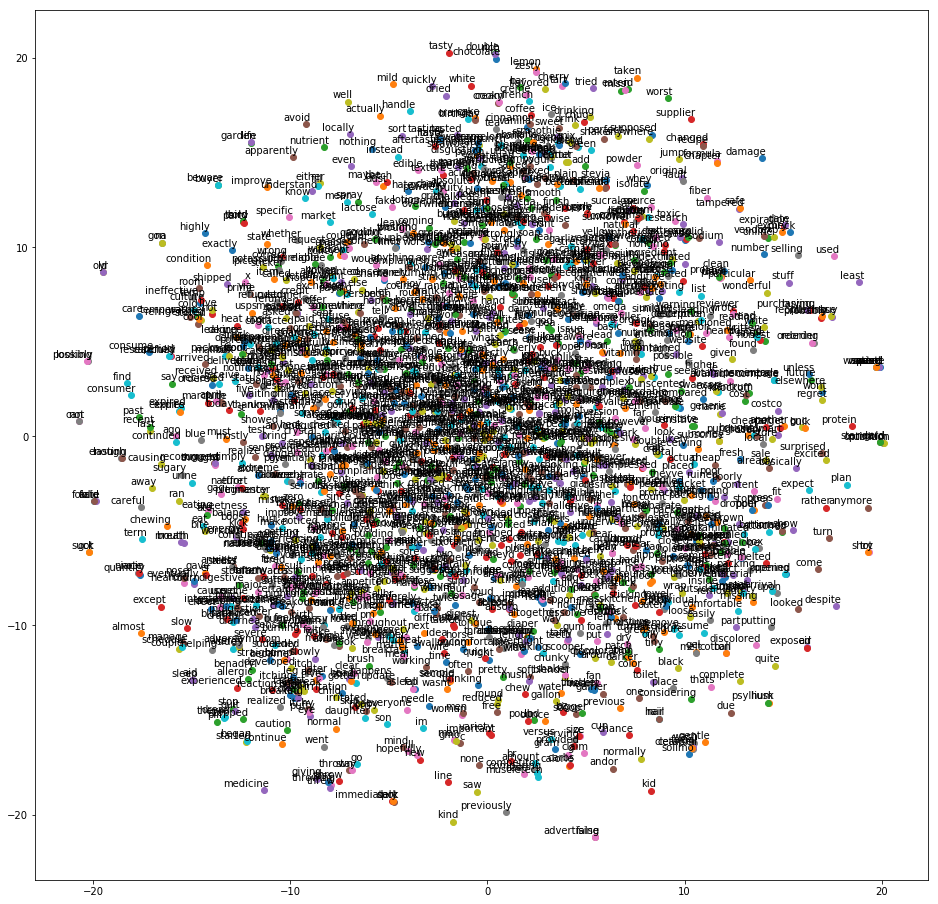

In [52]:
tsne_plot(model)

# XGboost

In [26]:
dtrain_local = xgb.DMatrix(data = train_local_vecs_w2v, label = train_local_Y[dep])
dtest_local = xgb.DMatrix(data = test_local_vecs_w2v, label = test_local_Y[dep])
dtrain_prod = xgb.DMatrix(data = train_prod_vecs_w2v, label = train_prod_Y[dep])
dtest_prod = xgb.DMatrix(data = test_prod_vecs_w2v)


num_rounds = 1000

params = {'objective' : 'multi:softprob',
          'num_class' : len(train_local_Y.topic.unique()),
          #'eval_metric': 'auc',
          'max_depth' : 7,
          'eta' : 0.3,
          'subsample': 1,
          'colsample_bytree': 1,
          'silent' : 1
          ,'tree_method' : 'gpu_hist'
          }

eval_set = [(dtrain_local,'train'), (dtest_local,'test')]

In [27]:
#Stopping. Best iteration:
#[106]	train-merror:0.288111	test-merror:0.488255
        
np.random.seed(100)
num_rounds = 1000
np.random.seed(100)
xgb_model = xgb.train(params,
                      dtrain_local,
                      evals = eval_set,
                      num_boost_round = num_rounds,
                      #feval = custom_mse,
                      verbose_eval = True,
                      early_stopping_rounds = 30)

xgb_local_pred = xgb_model.predict(dtest_local)

#Feature importance
pd.DataFrame.from_dict(xgb_model.get_score(), orient = 'index').rename(columns = {0:'importance'}).sort_values(['importance'], ascending = False)


[0]	train-merror:0.415388	test-merror:0.616331
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 30 rounds.
[1]	train-merror:0.361697	test-merror:0.5934
[2]	train-merror:0.335091	test-merror:0.582215
[3]	train-merror:0.325024	test-merror:0.566555
[4]	train-merror:0.317114	test-merror:0.556488
[5]	train-merror:0.309923	test-merror:0.554251
[6]	train-merror:0.306088	test-merror:0.540828
[7]	train-merror:0.301774	test-merror:0.542506
[8]	train-merror:0.298897	test-merror:0.536353
[9]	train-merror:0.2965	test-merror:0.535235
[10]	train-merror:0.294343	test-merror:0.534116
[11]	train-merror:0.292905	test-merror:0.532438
[12]	train-merror:0.291467	test-merror:0.531879
[13]	train-merror:0.290508	test-merror:0.532438
[14]	train-merror:0.28907	test-merror:0.529083
[15]	train-merror:0.28907	test-merror:0.525168
[16]	train-merror:0.28883	test-merror:0.524608
[17]	train-merror:0.288591	test-merror:0.521253
[18]	t

[167]	train-merror:0.288111	test-merror:0.491051
[168]	train-merror:0.288111	test-merror:0.491611
[169]	train-merror:0.288111	test-merror:0.491611
[170]	train-merror:0.288111	test-merror:0.491611
[171]	train-merror:0.288111	test-merror:0.49217
[172]	train-merror:0.288111	test-merror:0.49217
[173]	train-merror:0.288111	test-merror:0.49217
[174]	train-merror:0.288111	test-merror:0.49217
[175]	train-merror:0.288111	test-merror:0.49217
[176]	train-merror:0.288111	test-merror:0.49217
[177]	train-merror:0.288111	test-merror:0.491051
[178]	train-merror:0.288111	test-merror:0.491051
[179]	train-merror:0.288111	test-merror:0.491611
[180]	train-merror:0.288111	test-merror:0.490492
[181]	train-merror:0.288111	test-merror:0.490492
[182]	train-merror:0.288111	test-merror:0.491611
[183]	train-merror:0.288111	test-merror:0.490492
[184]	train-merror:0.288111	test-merror:0.489933
[185]	train-merror:0.288111	test-merror:0.489933
[186]	train-merror:0.288111	test-merror:0.489933
[187]	train-merror:0.28811

,importance
f169,849
f0,848
f13,779
f39,764
f1,764
f24,738
f85,736
f127,732
f58,727
f68,721


In [28]:
np.random.seed(100)
xgb_model_prod = xgb.train(params,
                           dtrain_prod,
                           evals = eval_set,
                           num_boost_round = xgb_model.best_iteration + 10
                           #feval = custom_mse,
                           #verbose_eval = True,
                           #early_stopping_rounds = 20
                          )


xgb_prod_pred = xgb_model_prod.predict(dtest_prod)


[0]	train-merror:0.429291	test-merror:0.436242
[1]	train-merror:0.377756	test-merror:0.386465
[2]	train-merror:0.351151	test-merror:0.355145
[3]	train-merror:0.333893	test-merror:0.338367
[4]	train-merror:0.325503	test-merror:0.329978
[5]	train-merror:0.316635	test-merror:0.318792
[6]	train-merror:0.310163	test-merror:0.314877
[7]	train-merror:0.307047	test-merror:0.309843
[8]	train-merror:0.302732	test-merror:0.304251
[9]	train-merror:0.300096	test-merror:0.302013
[10]	train-merror:0.297699	test-merror:0.300895
[11]	train-merror:0.295781	test-merror:0.300336
[12]	train-merror:0.294823	test-merror:0.299776
[13]	train-merror:0.293145	test-merror:0.298658
[14]	train-merror:0.292426	test-merror:0.298658
[15]	train-merror:0.291707	test-merror:0.298098
[16]	train-merror:0.290508	test-merror:0.297539
[17]	train-merror:0.290029	test-merror:0.29698
[18]	train-merror:0.289549	test-merror:0.29698
[19]	train-merror:0.28907	test-merror:0.29698
[20]	train-merror:0.28883	test-merror:0.29698
[21]	tra

[170]	train-merror:0.288111	test-merror:0.296421
[171]	train-merror:0.288111	test-merror:0.296421
[172]	train-merror:0.288111	test-merror:0.296421
[173]	train-merror:0.288111	test-merror:0.296421
[174]	train-merror:0.288111	test-merror:0.296421
[175]	train-merror:0.288111	test-merror:0.296421
[176]	train-merror:0.288111	test-merror:0.296421
[177]	train-merror:0.288111	test-merror:0.296421
[178]	train-merror:0.288111	test-merror:0.296421
[179]	train-merror:0.288111	test-merror:0.296421
[180]	train-merror:0.288111	test-merror:0.296421
[181]	train-merror:0.288111	test-merror:0.296421
[182]	train-merror:0.288111	test-merror:0.296421
[183]	train-merror:0.288111	test-merror:0.296421
[184]	train-merror:0.288111	test-merror:0.296421
[185]	train-merror:0.288111	test-merror:0.296421
[186]	train-merror:0.288111	test-merror:0.296421
[187]	train-merror:0.288111	test-merror:0.296421
[188]	train-merror:0.288111	test-merror:0.296421
[189]	train-merror:0.288111	test-merror:0.296421
[190]	train-merror:0

#### XGB prod submission

In [30]:
#XGB_prod_pred = xgb_model_prod.predict_proba(test_prod_vecs_w2v)
DF_test_prod = pd.read_csv('test.csv')

top_n_predictions = np.fliplr(np.argsort(xgb_prod_pred, axis = 1))
top_class = LE.inverse_transform(top_n_predictions)
DF_test_prod['topic'] = top_class.tolist()
DF_test_prod = DF_test_prod.loc[~DF_test_prod['Review Text'].duplicated(),]

DF_test_prod.head()

submission = pd.read_csv('Test.csv')
submission['seq'] = submission.groupby(['Review Text']).cumcount()

print(submission.shape, DF_test_prod.shape)
#submission.head()

submission = submission.merge(DF_test_prod[['Review Text', 'topic']], how = 'left',
                              left_on = ['Review Text'], right_on = ['Review Text'] )
submission.head(10)

final_list = []
for index, row in submission.iterrows():
#     print(index)
#     print(submission['seq'][index])
#     print("")
#     print(submission['topic'][index][submission['seq'][index]])
    temp = submission['topic'][index][submission['seq'][index]]
#   temp = submission['topic'][index][0]
    final_list.append(temp)
submission['topic'] = final_list
#submission['topic'] = LE.inverse_transform(submission['topic'])
submission.drop(['seq'], axis =1, inplace = True)

submission.to_csv('XGB_sub_10.csv', index = False)
submission.head()


C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(2553, 3) (1772, 3)


,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
1,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Quality/Contaminated
